In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
import joblib
import os


In [13]:


df = pd.read_csv("data/driver.csv")

df['date_from'] = pd.to_datetime(df['date_from'])
df['date_to'] = pd.to_datetime(df['date_to'])

print(f"Data Loaded: {df.shape}")
print (df)



Data Loaded: (11507, 23)
          id  driver_id   driver_ssign_id             imei  \
0         13         24  7F00000118A12701  357544374129480   
1         14         24  7F00000118A12701  357544372502167   
2         15         24  7F00000118A12701  357544374129480   
3         16         24  7F00000118A12701  357544374163562   
4         17         24  7F00000118A12701  357544372502167   
...      ...        ...               ...              ...   
11502  13294       7729               NaN  861076080610452   
11503  13295       7730               NaN  861076083847564   
11504  13296       7731               NaN  861076080609629   
11505  13297       7732               NaN  861076080270364   
11506  13298       7733               NaN  861076080610437   

                date_from             date_to  overspeed_accuracy  \
0     2025-11-07 03:23:43 2025-11-07 07:17:56                   0   
1     2025-11-09 08:40:21 2025-11-10 00:00:00                  23   
2     2025-11-10 04:05:

In [14]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11507 entries, 0 to 11506
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  11507 non-null  int64         
 1   driver_id           11507 non-null  int64         
 2   driver_ssign_id     4607 non-null   object        
 3   imei                11507 non-null  int64         
 4   date_from           11507 non-null  datetime64[ns]
 5   date_to             11507 non-null  datetime64[ns]
 6   overspeed_accuracy  11507 non-null  int64         
 7   overspeed_zone      11507 non-null  int64         
 8   overspeed_road      11507 non-null  int64         
 9   overspeed_standard  11507 non-null  int64         
 10  os_acc_distance     11507 non-null  float64       
 11  os_zo_distance      11507 non-null  int64         
 12  os_ro_distance      11507 non-null  int64         
 13  os_st_distance      11507 non-null  float64   

In [15]:
print(df.describe())


                 id     driver_id          imei  \
count  11507.000000  11507.000000  1.150700e+04   
mean    7495.740940   2674.550187  5.524061e+14   
min       13.000000      3.000000  2.159650e+09   
25%     4628.500000   1200.000000  3.540171e+14   
50%     7545.000000   2032.000000  3.596321e+14   
75%    10421.500000   3887.000000  8.646361e+14   
max    13298.000000   7752.000000  8.698670e+14   
std     3401.394728   2024.626106  3.119737e+14   

                           date_from                        date_to  \
count                          11507                          11507   
mean   2025-12-04 05:39:56.681411584  2025-12-05 01:24:41.217345792   
min              2025-11-04 00:39:48            2025-11-04 03:05:27   
25%              2025-12-02 04:00:39            2025-12-03 00:00:00   
50%              2025-12-04 05:15:20            2025-12-05 00:00:00   
75%              2025-12-07 00:00:00            2025-12-07 09:19:15   
max              2025-12-08 23:18:29       

In [16]:
# Check Missing Values
missing_percentage = df.isnull().mean() * 100
print("Missing Values:")
print(missing_percentage[missing_percentage > 0])

# Check Driver Keys
keys_per_driver = df.groupby('driver_id')['driver_ssign_id'].nunique()
print(f"\nMax keys per driver: {keys_per_driver.max()}")

Missing Values:
driver_ssign_id    59.9635
dtype: float64

Max keys per driver: 1


In [17]:
df_check = df.copy()

# Calculate average trip speed using distance and duration (in hours).
# Replace zero duration with NaN to avoid divide-by-zero issues.

duration_hours = df_check["duration_traveled"] / 3600
duration_hours = duration_hours.replace(0, np.nan)

# Mark trips with zero distance/time or very high speed (>=120 km/h) as invalid.

df_check["calc_speed"] = df_check["distance_traveled"] / duration_hours

quantiles = df_check['calc_speed'].quantile([0.90, 0.95, 0.99, 0.999, 1.0])
print(quantiles)

#Identify Invalid Rows (Logic Check)
check1 = df.copy()
check1['speed_check'] = check1['distance_traveled'] / (check1['duration_traveled'] / 3600)

# From the speed distribution, ~99% of trips are below ~80 km/h, so I added ~40 km/h as a buffer;
# any average speed ≥120 km/h is treated as an outlier compared to the typical behavior.
mask_rejected = (
    (check1['speed_check'] >= 120) | 
    (check1['distance_traveled'] <= 0) | 
    (check1['duration_traveled'] <= 0)
)   
rejected_rows = check1[mask_rejected]

print(f"\nRows to be rejected (Physics Errors): {len(rejected_rows)}")
print(f" - Zero Distance: {len(rejected_rows[rejected_rows['distance_traveled'] <= 0])}")
print(f" - Impossible Speed (>120): {len(rejected_rows[rejected_rows['speed_check'] >= 120])}")
print("\nSample of rejected rows:")
print(rejected_rows[['driver_id', 'distance_traveled', 'duration_traveled', 'speed_check']].head())

0.900       56.637619
0.950       63.855099
0.990       80.482578
0.999      301.889393
1.000    98112.000000
Name: calc_speed, dtype: float64

Rows to be rejected (Physics Errors): 2405
 - Zero Distance: 2381
 - Impossible Speed (>120): 24

Sample of rejected rows:
    driver_id  distance_traveled  duration_traveled  speed_check
3          24                0.0                  0          NaN
7          20                0.0                  0          NaN
28       4148                0.0                  0          NaN
37       4184                0.0                  0          NaN
47       4257                0.0                  0          NaN



--- Correlation Matrix ---
                    overspeed_standard  overspeed_accuracy  os_st_distance  \
overspeed_standard            1.000000            0.050704        0.721215   
overspeed_accuracy            0.050704            1.000000        0.054315   
os_st_distance                0.721215            0.054315        1.000000   
os_acc_distance               0.077205            0.880202        0.092913   

                    os_acc_distance  
overspeed_standard         0.077205  
overspeed_accuracy         0.880202  
os_st_distance             0.092913  
os_acc_distance            1.000000  


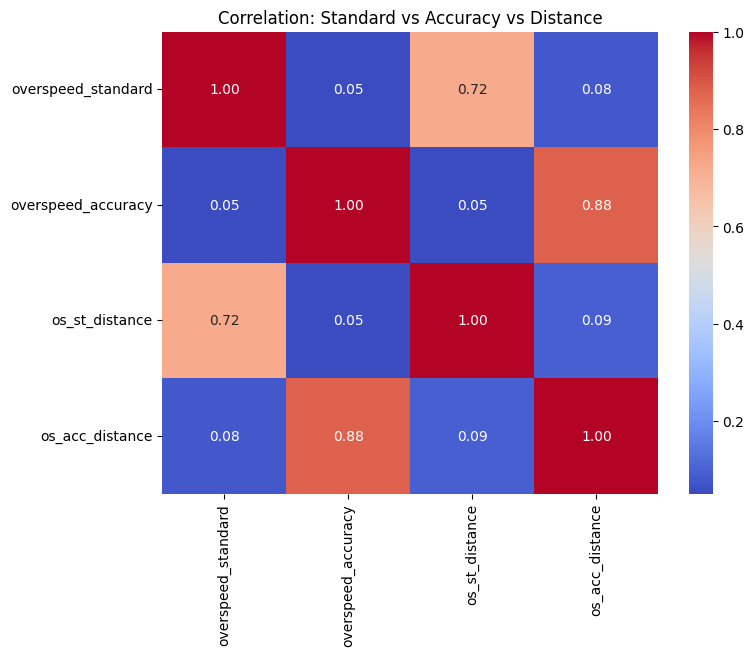

In [18]:
#Feature Selection Analysis ---

cols_to_check = ['overspeed_standard', 'overspeed_accuracy', 'os_st_distance', 'os_acc_distance']

# Calculate Correlation
correlation = df[cols_to_check].corr()
print("\n--- Correlation Matrix ---")
print(correlation)

# Visual Proof
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation: Standard vs Accuracy vs Distance")
plt.show()

# Strong correlation between overspeed_standard and os_st_distance (~0.72),
# and between overspeed_accuracy and os_acc_distance (~0.88) → each pair is redundant.
# Low correlation between the two groups (~0.05–0.09) → they capture different behaviors.
# Decision: keep one feature from each pair (e.g. overspeed_standard and overspeed_accuracy).



--- Risk Threshold Analysis ---
Threshold (> X)    | Risky Drivers   | Percentage (%) 
-------------------------------------------------------
> 5                 | 5417            | 47.1%
> 10                | 4120            | 35.8%
> 15                | 3061            | 26.6%
> 20                | 2247            | 19.5%  <-- Selected
> 25                | 1689            | 14.7%
> 50                | 332             | 2.9%


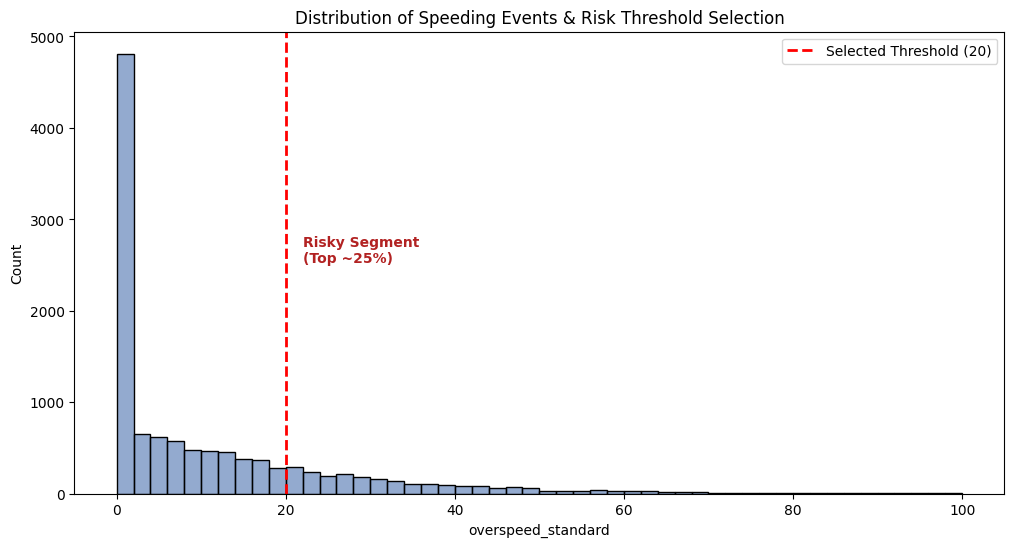

In [19]:
#Target Threshold Justification ---

# 1. Sensitivity Analysis Loop
thresholds = [5, 10, 15, 20, 25, 50]
print("\n--- Risk Threshold Analysis ---")
print(f"{'Threshold (> X)':<18} | {'Risky Drivers':<15} | {'Percentage (%)':<15}")
print("-" * 55)

for t in thresholds:
    # Use df (raw) or df_clean (if defined previously) for this check
    # Using df here to show distribution on raw data
    count = (df['overspeed_standard'] > t).sum()
    percent = (count / len(df)) * 100
    marker = "  <-- Selected" if t == 20 else ""
    print(f"> {t:<17} | {count:<15} | {percent:.1f}%{marker}")

# 2. Long-Tail Visualization
plt.figure(figsize=(12, 6))
plot_data = df[df['overspeed_standard'] <= 100]['overspeed_standard']

sns.histplot(plot_data, bins=50, kde=False, color='#4c72b0', alpha=0.6)
plt.axvline(x=20, color='red', linestyle='--', linewidth=2, label='Selected Threshold (20)')
plt.text(22, plt.gca().get_ylim()[1]*0.5, 'Risky Segment\n(Top ~25%)', color='firebrick', fontweight='bold')

plt.title('Distribution of Speeding Events & Risk Threshold Selection')
plt.legend()
plt.show()

In [20]:
df_clean = df.copy()

# 2. Drop Columns 
cols_to_drop = [
    'driver_ssign_id',
    'overspeed_zone', 'overspeed_road', 'os_zo_distance', 'os_ro_distance',
    'type', 'imei',
    'overspeed_accuracy', 'os_acc_distance', 'os_st_distance'
]
df_clean.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 3. Drop duplicates
df_clean.drop_duplicates(inplace=True)

# 4. Physics filter
#    - remove non-positive distance / duration
mask_positive = (df_clean['distance_traveled'] > 0) & (df_clean['duration_traveled'] > 0)
df_clean = df_clean[mask_positive].copy()

#    - compute average speed (km/h)
temp_speed = df_clean['distance_traveled'] / (df_clean['duration_traveled'] / 3600)

#    - remove unrealistic high average speeds (>= 120 km/h)
df_clean = df_clean[temp_speed < 120].copy()

# 5. Trip-level risk target: risky if overspeed_standard > 20
df_clean['is_risky'] = (df_clean['overspeed_standard'] > 20).astype(int)

print(f"Clean Data Shape: {df_clean.shape}")


Clean Data Shape: (9102, 14)


In [21]:
df_eng = df_clean.copy()

# 1) Temporal features: when the trip started (hour, weekday, weekend flag)
df_eng["hour"] = df_eng["date_from"].dt.hour
df_eng["day_of_week"] = df_eng["date_from"].dt.dayofweek  # Monday=0 ... Sunday=6

# In this dataset we treat Friday (4) and Saturday (5) as weekend days (Jordan context).
df_eng["is_weekend"] = df_eng["day_of_week"].isin([4, 5]).astype(int)

def get_time_category(h: int) -> int:
    """
    0 = normal hours
    1 = rush hours (morning/evening traffic)
    2 = night/early-morning (higher risk context)
    """
    if 7 <= h <= 9 or 16 <= h <= 19:
        return 1      # rush hours
    elif 0 <= h <= 5:
        return 2      # night / very early morning
    else:
        return 0      # normal time

df_eng["time_category"] = df_eng["hour"].apply(get_time_category)


# 2) Sanity check on engine_idle:
#    Make sure idle time never exceeds the trip duration
df_eng["engine_idle"] = df_eng[["engine_idle", "duration_traveled"]].min(axis=1)

# If idle == duration, we slightly reduce it (0.99x) so that moving_time > 0
# This avoids zero moving_time and division-by-zero later.
df_eng["engine_idle"] = np.where(
    df_eng["engine_idle"] == df_eng["duration_traveled"],
    df_eng["duration_traveled"] * 0.99,
    df_eng["engine_idle"]
)


# 3) Trip-level derived features (speed & ratios)

# Average trip speed over the whole moving duration (km/h)
df_eng["avg_speed_kmh"] = df_eng["distance_traveled"] / (df_eng["duration_traveled"] / 3600)

# Effective moving time (seconds) = driving time minus idle time
# We clip at 1 second to avoid negative or zero moving time due to noise/rounding.
df_eng["moving_time_sec"] = (df_eng["duration_traveled"] - df_eng["engine_idle"]).clip(lower=1)

# Average speed while actually moving (km/h)
df_eng["moving_speed_kmh"] = df_eng["distance_traveled"] / (df_eng["moving_time_sec"] / 3600)

# Hard cap moving speed to 200 km/h to avoid rare extreme outliers dominating the model
df_eng.loc[df_eng["moving_speed_kmh"] > 200, "moving_speed_kmh"] = 200
df_eng.loc[df_eng["moving_speed_kmh"] < 0, "moving_speed_kmh"] = 0

# Ratio of idle time to total trip duration (0–1, higher = more wasted/idle time)
df_eng["idle_ratio"] = df_eng["engine_idle"] / (df_eng["duration_traveled"] + 1e-6)

# Engine_work per km: rough efficiency / engine usage intensity indicator
df_eng["work_per_km"] = df_eng["engine_work"] / (df_eng["distance_traveled"] + 1e-6)

# Seatbelt ratio: share of the trip spent without seat belt (higher = worse habit)
df_eng["seatbelt_ratio"] = df_eng["seat_belt"] / (df_eng["duration_traveled"] + 1e-6)


# 4) Aggregations per driver (driver-level behavior, not only trip-level)

# Average moving speed across all trips of the same driver
df_eng["driver_avg_moving_speed"] = df_eng.groupby("driver_id")["moving_speed_kmh"].transform("mean")

# Total distance driven by the driver (km)
df_eng["driver_total_km"] = df_eng.groupby("driver_id")["distance_traveled"].transform("sum")

# Average overspeed events per trip for the driver (how "overspeedy" they tend to be)
df_eng["driver_risk_tendency"] = df_eng.groupby("driver_id")["overspeed_standard"].transform("mean")

# Average seatbelt seconds per trip (baseline seatbelt habit per driver)
df_eng["driver_seatbelt_habit"] = df_eng.groupby("driver_id")["seat_belt"].transform("mean")


# 5) Time-of-day risk context (kept as a simple feature, not used to build a manual risk score)
#    1.0 = normal; 1.5 = rush hour; 2.0 = night. This is a heuristic encoding of context risk.
df_eng["context_weight"] = 1.0
df_eng.loc[df_eng["time_category"] == 1, "context_weight"] = 1.5
df_eng.loc[df_eng["time_category"] == 2, "context_weight"] = 2.0
# NOTE: we keep context_weight as a standalone feature and let the model learn how important it is,
# instead of manually mixing it into a hand-crafted weighted_risk_score.


# 6) Fatigue indicator: long trips may indicate fatigue risk
df_eng["trip_hours"] = df_eng["duration_traveled"] / 3600
# Simple rule: mark trips longer than 4 hours as potentially fatigued
df_eng["is_fatigued"] = (df_eng["trip_hours"] > 4).astype(int)


# Final cleanup: guard against any remaining inf / NaN from divisions on tiny values
df_eng.replace([np.inf, -np.inf], 0, inplace=True)
df_eng.fillna(0, inplace=True)

print("--- Feature engineering completed ---")
print(df_eng[["avg_speed_kmh", "moving_speed_kmh", "idle_ratio", "seatbelt_ratio"]].describe())


--- Feature engineering completed ---
       avg_speed_kmh  moving_speed_kmh   idle_ratio  seatbelt_ratio
count    9102.000000       9102.000000  9102.000000     9102.000000
mean       35.460042        174.890317     0.874658        0.005792
std        16.625931         55.796391     0.271157        0.003719
min         0.060000          0.120805     0.000000        0.000000
25%        25.870711        200.000000     0.990000        0.003252
50%        35.538222        200.000000     0.990000        0.005478
75%        45.473600        200.000000     0.990000        0.007760
max       108.858804        200.000000     0.998238        0.052632


In [23]:
# Features selected for the supervised model (RandomForest)
features_to_use = [
    "distance_traveled", "overspeed_standard", "seat_belt",
    "hour", "is_weekend", "time_category",
    "moving_speed_kmh", "avg_speed_kmh", "idle_ratio", "seatbelt_ratio", "is_fatigued",
    "driver_risk_tendency", "driver_seatbelt_habit", "driver_total_km", "context_weight"
]

# Final feature matrix (no scaling needed for tree-based models like RandomForest)
df_final = df_eng[features_to_use].copy()

# Attach binary target (trip-level risk label)
df_final["TARGET_is_risky"] = df_eng["is_risky"].astype(int).values

print(df_final.head())


   distance_traveled  overspeed_standard  seat_belt  hour  is_weekend  \
0              44.84                   0          8     3           1   
1             287.90                  46         92     8           0   
2              81.46                   3         26     4           0   
4             112.07                   9         20     4           0   
5             342.14                  13         58     2           0   

   time_category  moving_speed_kmh  avg_speed_kmh  idle_ratio  seatbelt_ratio  \
0              2        200.000000      39.342920    0.990000        0.001950   
1              1        200.000000      52.427538    0.990000        0.004654   
2              2        200.000000      48.520185    0.990000        0.004302   
4              2        200.000000      50.761449    0.990000        0.002516   
5              2        173.503874      50.787729    0.707282        0.002392   

   is_fatigued  driver_risk_tendency  driver_seatbelt_habit  driver_total_

--- Training K-Means Models (Finding Optimal K) ---


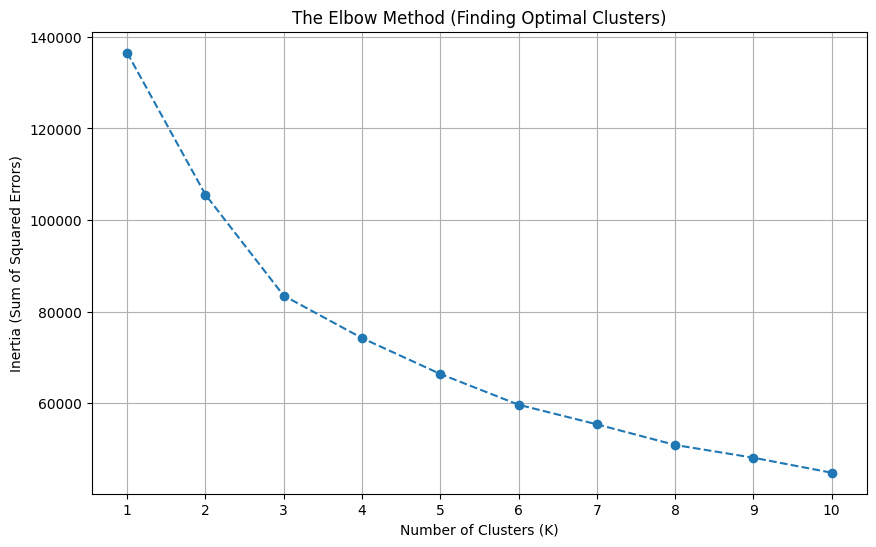

In [24]:
# Use the same feature set (or a subset) for clustering
features_to_use = [
    "distance_traveled", "overspeed_standard", "seat_belt",
    "hour", "is_weekend", "time_category",
    "moving_speed_kmh", "avg_speed_kmh", "idle_ratio", "seatbelt_ratio", "is_fatigued",
    "driver_risk_tendency", "driver_seatbelt_habit", "driver_total_km", "context_weight"
]

# Raw feature data for clustering
X_cluster = df_eng[features_to_use].copy()

# K-Means is distance-based → we standardize features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Elbow method: compute inertia (SSE) for different K values
inertia = []
k_range = range(1, 11)

print("--- Training K-Means Models (Finding Optimal K) ---")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve to visually pick a good K
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker="o", linestyle="--")
plt.title("The Elbow Method (Finding Optimal Clusters)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Errors)")
plt.xticks(k_range)
plt.grid(True)
plt.show()


--- Clustering completed ---
Number of trips in each cluster:
cluster
0    2118
1    2104
2    4880
Name: count, dtype: int64


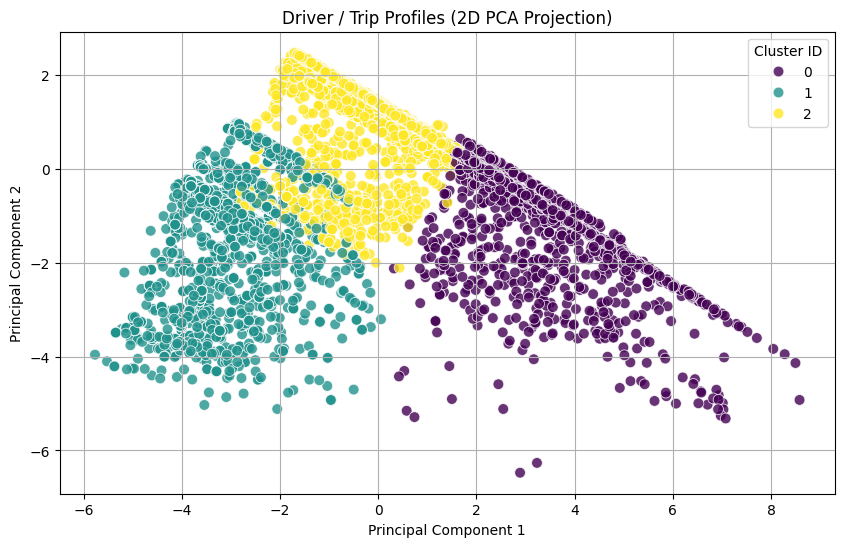


--- Cluster Profiles (mean values per cluster) ---
         moving_speed_kmh  overspeed_standard  seatbelt_ratio  idle_ratio  \
cluster                                                                     
0                  183.32               32.80            0.01        0.91   
1                  147.26                5.09            0.01        0.73   
2                  183.15                9.30            0.01        0.92   

         is_fatigued  distance_traveled  driver_risk_tendency  count  
cluster                                                               
0               0.92             240.45                 27.54   2118  
1               0.04              44.97                  6.83   2104  
2               0.14              86.78                 10.84   4880  


In [25]:
# 1) Run K-Means with K=3 (chosen from the Elbow method)
k_opt =3
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)

# Fit on the scaled feature matrix used for clustering
cluster_labels = kmeans.fit_predict(X_scaled)

# Attach cluster labels back to the engineered dataframe for interpretation
df_eng["cluster"] = cluster_labels

print("--- Clustering completed ---")
print("Number of trips in each cluster:")
print(df_eng["cluster"].value_counts().sort_index())


# 2) 2D visualization using PCA on the same scaled features
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=df_eng["cluster"],
    palette="viridis",
    s=60,
    alpha=0.8
)
plt.title("Driver / Trip Profiles (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster ID")
plt.grid(True)
plt.show()


# 3) Cluster profiling: average behavior per cluster
print("\n--- Cluster Profiles (mean values per cluster) ---")

profile = df_eng.groupby("cluster")[[
    "moving_speed_kmh",      # actual moving speed
    "overspeed_standard",    # overspeed events per trip
    "seatbelt_ratio",        # share of time without seatbelt
    "idle_ratio",            # share of idle time
    "is_fatigued",           # long trips indicator
    "distance_traveled",     # average trip distance
    "driver_risk_tendency"   # driver-level overspeed tendency
]].mean()

# Add trip count per cluster
profile["count"] = df_eng.groupby("cluster").size()

print(profile.round(2))


In [26]:
print("--- 1. Clustering Quality (Internal Metric) ---")

# Silhouette score checks how well-separated the K-Means clusters are (-1 to 1).
# We use the scaled feature space (X_scaled) and the cluster labels we assigned earlier.
sample_size = 10000 if len(X_scaled) > 10000 else len(X_scaled)
sil_score = silhouette_score(X_scaled[:sample_size], df_eng["cluster"][:sample_size])

print(f"Clustering Silhouette Score: {sil_score:.3f}")
print("(Rule of thumb: > 0.5 = strong structure, ~0.25–0.5 = reasonable, < 0.2 = weak.)")


--- 1. Clustering Quality (Internal Metric) ---
Clustering Silhouette Score: 0.274
(Rule of thumb: > 0.5 = strong structure, ~0.25–0.5 = reasonable, < 0.2 = weak.)


--- Silhouette per K ---
K = 2: silhouette = 0.372
K = 3: silhouette = 0.324
K = 4: silhouette = 0.355
K = 5: silhouette = 0.326
K = 6: silhouette = 0.316

Best K based on silhouette = 2 (score = 0.372)


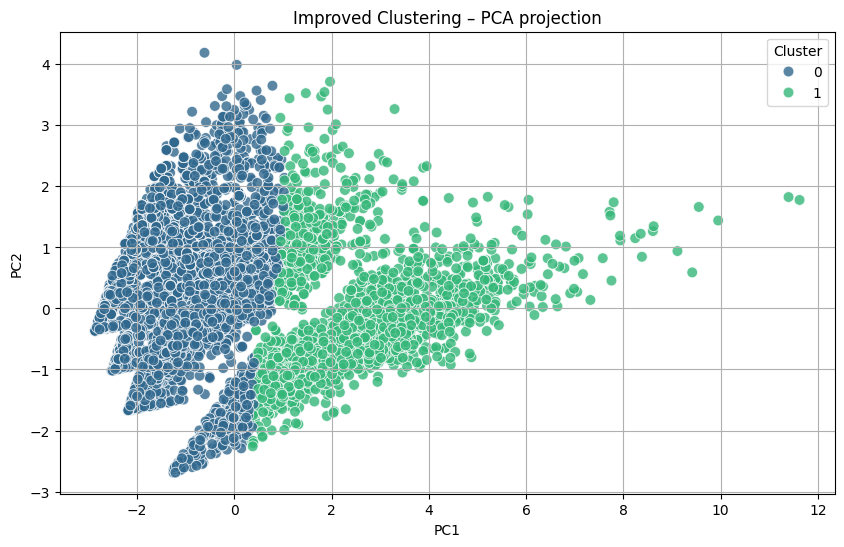


Final silhouette with K=2: 0.372


In [27]:
# 1) Choose a smaller, more informative feature set for clustering
cluster_features = [
    "overspeed_standard",
    "driver_risk_tendency",
    "avg_speed_kmh",
    "distance_traveled",
    "is_fatigued",
    "time_category"
]

X_cluster = df_eng[cluster_features].copy()

# 2) Scale features (K-Means is distance-based)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 3) Try multiple K values and compute silhouette for each to pick the best
print("--- Silhouette per K ---")
best_k = None
best_score = -1

for k in range(2, 7):  # try K = 2..6
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(X_scaled)
    score_tmp = silhouette_score(X_scaled, labels_tmp)
    print(f"K = {k}: silhouette = {score_tmp:.3f}")
    
    if score_tmp > best_score:
        best_score = score_tmp
        best_k = k

print(f"\nBest K based on silhouette = {best_k} (score = {best_score:.3f})")

# 4) Fit final K-Means with best_k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
df_eng["cluster"] = cluster_labels

# 5) Optional: PCA visualization
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pc[:, 0],
    y=pc[:, 1],
    hue=df_eng["cluster"],
    palette="viridis",
    s=60,
    alpha=0.8
)
plt.title("Improved Clustering – PCA projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# 6) New silhouette score
sil_score = silhouette_score(X_scaled, df_eng["cluster"])
print(f"\nFinal silhouette with K={best_k}: {sil_score:.3f}")


In [28]:
# Features we used for clustering
cluster_features = [
    "overspeed_standard",
    "driver_risk_tendency",
    "avg_speed_kmh",
    "distance_traveled",
    "is_fatigued",
    "time_category"
]

print("\n--- Cluster profiles (mean per cluster) ---")
cluster_profile = df_eng.groupby("cluster")[cluster_features].mean()

# Add size of each cluster
cluster_profile["count"] = df_eng.groupby("cluster").size()

print(cluster_profile.round(2))



--- Cluster profiles (mean per cluster) ---
         overspeed_standard  driver_risk_tendency  avg_speed_kmh  \
cluster                                                            
0                      6.70                  8.86          32.71   
1                     31.09                 25.83          42.15   

         distance_traveled  is_fatigued  time_category  count  
cluster                                                        
0                    63.26         0.07           1.47   6453  
1                   233.72         0.85           1.95   2649  



--- RandomForest Performance on is_risky ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1373
           1       1.00      1.00      1.00       448

    accuracy                           1.00      1821
   macro avg       1.00      1.00      1.00      1821
weighted avg       1.00      1.00      1.00      1821


--- Top Features ---
                  feature  importance
1      overspeed_standard    0.594092
0       distance_traveled    0.122693
11   driver_risk_tendency    0.102420
2               seat_belt    0.048491
10            is_fatigued    0.031385
7           avg_speed_kmh    0.027994
13        driver_total_km    0.025895
12  driver_seatbelt_habit    0.025336
9          seatbelt_ratio    0.008475
3                    hour    0.005439


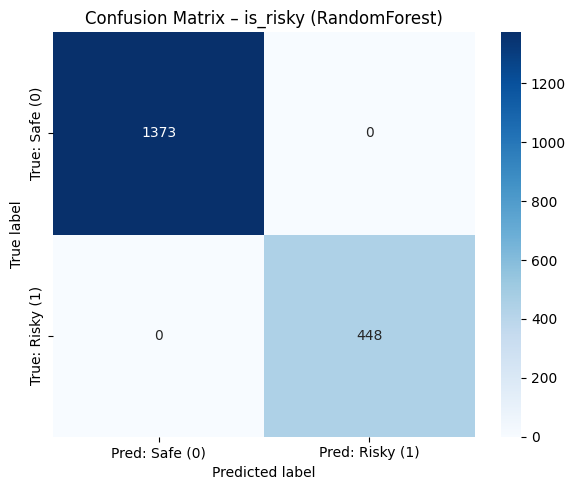

In [29]:
# 1) Features to be used by the supervised model (same as we agreed before)
features_to_use = [
    "distance_traveled", "overspeed_standard", "seat_belt",
    "hour", "is_weekend", "time_category",
    "moving_speed_kmh", "avg_speed_kmh", "idle_ratio", "seatbelt_ratio", "is_fatigued",
    "driver_risk_tendency", "driver_seatbelt_habit", "driver_total_km", "context_weight"
]

# 2) X = features, y = binary risk label
X = df_eng[features_to_use].copy()
y = df_eng["is_risky"].astype(int)

# 3) Train/Test split with stratification to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4) Train a baseline RandomForest classifier
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 5) Evaluate on test set
y_pred = rf_model.predict(X_test)

print("\n--- RandomForest Performance on is_risky ---")
print(classification_report(y_test, y_pred))

# 6) Feature importance: which signals are most important for risk prediction
feat_importance = (
    pd.DataFrame({
        "feature": features_to_use,
        "importance": rf_model.feature_importances_
    })
    .sort_values(by="importance", ascending=False)
)

print("\n--- Top Features ---")
print(feat_importance.head(10))

# 7) Confusion matrix for a quick view of errors
plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred: Safe (0)", "Pred: Risky (1)"],
    yticklabels=["True: Safe (0)", "True: Risky (1)"]
)
plt.title("Confusion Matrix – is_risky (RandomForest)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


--- Final Driver Profile Distribution (trip-level) ---
Driver_Profile
Lower-risk (short/medium trips)         6453
High-risk (long-distance & fatigued)    2649
Name: count, dtype: int64

✅ PROJECT SNAPSHOT EXPORTED as 'Driver_Risk_Analysis_Final.csv'


C:\Users\MSI Laptop\AppData\Local\Temp\ipykernel_26388\1389318213.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


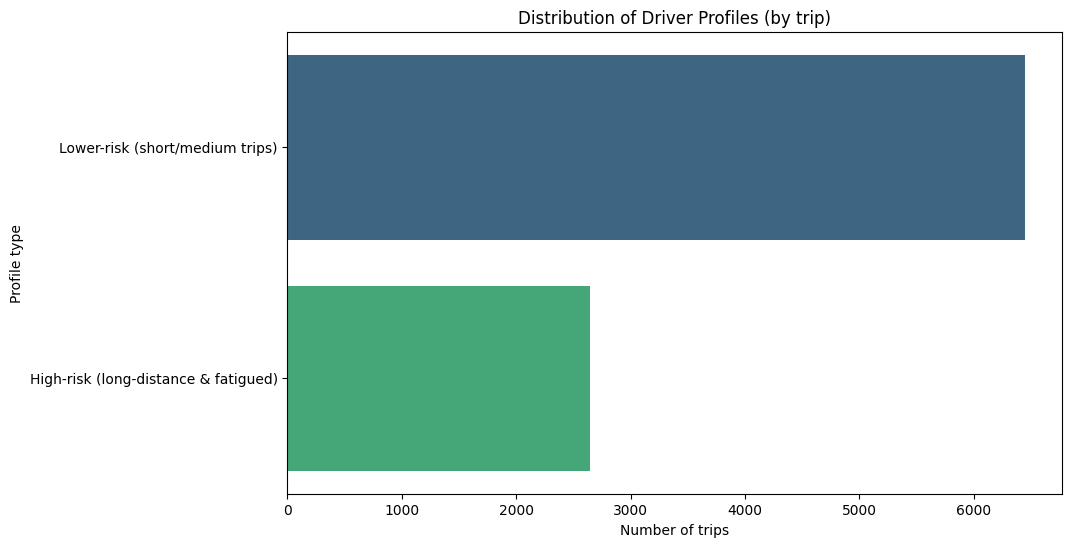

In [30]:
# 1. Map Cluster IDs to human-readable names (for K=2 setup)
# Cluster 0 = lower-risk / shorter trips
# Cluster 1 = high-risk / long-distance, fatigued

cluster_names = {
    0: "Lower-risk (short/medium trips)",
    1: "High-risk (long-distance & fatigued)"
}

# Apply names to a new column (trip-level profile)
df_eng["Driver_Profile"] = df_eng["cluster"].map(cluster_names)

# 2. Final sanity check
print("--- Final Driver Profile Distribution (trip-level) ---")
print(df_eng["Driver_Profile"].value_counts())

# 3. Export full dataset with profiles
df_eng.to_csv("Driver_Risk_Analysis_Final.csv", index=False)
print("\n✅ PROJECT SNAPSHOT EXPORTED as 'Driver_Risk_Analysis_Final.csv'")

# 4. Simple bar plot for the report
plt.figure(figsize=(10, 6))
sns.countplot(
    y="Driver_Profile",
    data=df_eng,
    palette="viridis",
    order=df_eng["Driver_Profile"].value_counts().index
)
plt.title("Distribution of Driver Profiles (by trip)")
plt.xlabel("Number of trips")
plt.ylabel("Profile type")
plt.show()


In [32]:
os.makedirs("models", exist_ok=True)

features_no_leak = [
    "distance_traveled",
    "seat_belt",
    "hour", "is_weekend", "time_category",
    "moving_speed_kmh", "avg_speed_kmh",
    "idle_ratio", "seatbelt_ratio",
    "is_fatigued",
    "driver_seatbelt_habit",
    "driver_total_km",
    "context_weight"
]

joblib.dump(rf_model, "models/rf_is_risky.pkl")
joblib.dump(features_no_leak, "models/features_no_leak.pkl")

print("Saved model and feature list to 'models/' ")

Saved model and feature list to 'models/' 
